In [1]:
import sys
sys.path.append('..')


import torch
import matplotlib.pyplot as plt
import yaml
import numpy as np
import random
from tqdm import tqdm
from torch.distributions import Normal
from utils.load_model import load_model


In [2]:
# Set seeds


seed = 42

# Set the seed for PyTorch
torch.manual_seed(seed)

# Set the seed for NumPy
np.random.seed(seed)

# Set the seed for Python's built-in random module
random.seed(seed)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')


In [3]:
# Load trained moddels

Checkpoint_iter = 100
dim_llm_embedding = 4

AUTO_REG_CKPT_PATH = f"/shared/share_mala/Leon/GP_{dim_llm_embedding}/autoreg-UQ-normal-Gradient-full-Loss-logprob-Horizon-2000_Noise_0.1/model_checkpoint_{Checkpoint_iter}.pt"
EXCG_CKPT_PATH = f"/shared/share_mala/Leon/GP_{dim_llm_embedding}/excg-UQ-normal-Gradient-full-Loss-logprob-Horizon-2000_Noise_0.1/model_checkpoint_{Checkpoint_iter}.pt"
Auto_reg_config_path = f"/user/al4263/TPA/scripts/gp_uq_normal_autoreg.yaml"
Excg_config_path = f"/user/al4263/TPA/scripts/gp_uq_normal_excg.yaml"

auto_reg_model = load_model(Auto_reg_config_path, AUTO_REG_CKPT_PATH, "autoreg", device)
excg_model = load_model(Excg_config_path, EXCG_CKPT_PATH, "excg", device)


In [4]:
# Generate new data on which we want to perform evaluation

# We should be careful of seeds here, we should not choose the seeds on which model was trained

# Set the params same as we trained on


from data.load_data import GPSamplerConstantDataset, scalar_collate_fn
from torch.utils.data import DataLoader

B = 10   #number of sequences on which we want to evaluate
noise = 0.1
test_horizon = 100
num_test_samples = 8192
mean_constant = 0.0
lengthscale = 1.0
outputscale = 1.0
x_range = (-2,2)

eval_dataset = GPSamplerConstantDataset(
        num_samples=num_test_samples, 
        noise = noise,
        dimension=dim_llm_embedding, 
        horizon=test_horizon)

eval_data_loader = DataLoader(eval_dataset, batch_size=B, shuffle=True, collate_fn=scalar_collate_fn)
batch = next(iter(eval_data_loader))
print(batch.x.shape, batch.y.shape)

/user/al4263/.conda/envs/llm_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


noise: 0.1
torch.Size([10, 100, 4]) torch.Size([10, 100, 1])


In [5]:
# Oracle GP model with which we will compare our results
import gpytorch

class CustomizableGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, mean_module, base_kernel, likelihood):
        super(CustomizableGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = mean_module
        self.covar_module = base_kernel
        self.likelihood = likelihood
    def forward(self, x):
        return gpytorch.distributions.MultivariateNormal(self.mean_module(x), self.covar_module(x))
        

# Define the modules
mean_module = gpytorch.means.ConstantMean()
base_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
likelihood = gpytorch.likelihoods.GaussianLikelihood()


#Setting the parameters of the model

#mean_module.constant = torch.nn.Parameter(torch.tensor([mean_constant]))
mean_module.constant = mean_constant
base_kernel.base_kernel.lengthscale = lengthscale
base_kernel.outputscale = outputscale
likelihood.noise_covar.noise = noise


oracle_model = CustomizableGPModel(None, None, mean_module, base_kernel, likelihood)

In [6]:
# Generating the distribution p(y_t|x_c;y_c;x_t) from the oracle model for the given context and target points

def oracle_model_predict(oracle_model, likelihood, xc, yc, xt):
    oracle_model.to(device)
    likelihood.to(device)
    oracle_model.set_train_data(inputs=xc, targets=yc, strict=False)

    oracle_model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        posterior = likelihood(oracle_model(xt))
        posterior_mean = posterior.mean
        posterior_var = posterior.variance
        return posterior_mean, posterior_var
        
# "oracle_model_predict_B" function is just for batching -  Generating the distribution p(y_t|x_c;y_c;x_t) from the oracle model for the given context and target points

def oracle_model_predict_B(oracle_model, likelihood, xc, yc, xt, B):
    means_B_oracle, vars_B_oracle = torch.zeros(B, xt.shape[1]), torch.zeros(B, xt.shape[1])
    for b in range(B):
        means_B_oracle[b, :], vars_B_oracle[b, :] = oracle_model_predict(
            oracle_model, likelihood, xc[b, :, :], yc[b, :, 0], xt[b, :, :]
        )
    return means_B_oracle, vars_B_oracle

In [7]:
from types import SimpleNamespace
class joint_prediction_machine:
    def __init__(self, uq_model, device):
        self.uq_model = uq_model
        self.device = device

    def joint_prediction(self, xc_data, yc_data, xt_data, T):
        inner_context_x = []
        inner_context_y = []
        device = self.device
        uq_model = self.uq_model
        batch_size = xt_data.shape[0]
        D = xt_data.shape[2]

        with torch.no_grad():
            for i in range(T):

                # Generate random contexts
                target_x = xt_data[:, i, :].unsqueeze(1)

                inner_xc = torch.cat(inner_context_x, dim=1) if inner_context_x else torch.empty(batch_size, 0, D, device=device)
                full_xc = torch.cat([xc_data, inner_xc], dim=1) 
                inner_yc = torch.cat(inner_context_y, dim=1) if inner_context_y else torch.empty(batch_size, 0, 1, device=device)
                full_yc = torch.cat([yc_data, inner_yc], dim=1) 
                full_xc = full_xc.to(device)
                full_yc = full_yc.to(device)
                batch = SimpleNamespace(
                    xc=full_xc,
                    yc=full_yc,
                    xt=target_x, 
                    yt=torch.zeros(batch_size, 1, 1, device=device)  
                )


                predicted_rewards = uq_model.predict(batch)
                inner_context_x.append(target_x)
                inner_context_y.append(predicted_rewards)

        # Concatenate all inner context data
        X = torch.cat(inner_context_x, dim=1)  
        y = torch.cat(inner_context_y, dim=1)  

        return X, y
    
    def marginal_prediction(self, xc_data, yc_data, xt_data, T):
        device = self.device
        uq_model = self.uq_model
        batch_size = xt_data.shape[0]
        D = xt_data.shape[2]

        with torch.no_grad():
            
            batch = SimpleNamespace(
                xc=xc_data,
                yc=yc_data,
                xt=xt_data, 
                yt=torch.zeros(batch_size, T, 1, device=device)  
            )
            predicted_rewards = uq_model.predict(batch) 

        return xt_data, predicted_rewards
    
    def permutation_prediction(self, eval_batch, P, T, marginal = False):
        xc_data = eval_batch.xc
        yc_data = eval_batch.yc
        xt_raw = eval_batch.xt
        B = xt_raw.shape[0]

        y_P_BxTxD = torch.zeros(P, B, xt_raw.shape[1], yc_data.shape[2], device=self.device)

        for p in range(P):
            # Generate a random permutation for each batch
            perm_indices = torch.randperm(xt_raw.shape[1])
            xt_data = xt_raw[:, perm_indices, :]
            if marginal:
                X, y = self.marginal_prediction(xc_data, yc_data, xt_data, T)
            else:
                X, y = self.joint_prediction(xc_data, yc_data, xt_data, T)
            # Permute back to original order
            y = y[:, perm_indices.argsort(), :]
            y = y.unsqueeze(0)
            y_P_BxTxD[p, :, :, :] = y

        return y_P_BxTxD

In [15]:
def estimating_losses(batch,
                      B, N, T, P, D,
                      y_P_BxTxD_list, context_continuous,
                      oracle_model, likelihood):


    P = y_P_BxTxD_list[0].shape[0]

    a1_loss_list = []
    a2_loss_list = []

    for y_P_BxTxD in y_P_BxTxD_list:

        a1_loss = 0
        a2_loss = 0
        b_loss = 0

        # for every permutation
        for p in range(P):
            # for filling in samples under oracle pps
            yt_true_oracle_BxT = torch.zeros(B, T).to(device)

            # for every step
            for t in range(T):

                # add xt[:, :step, :] to xc to determine the full oracle context x at this step - resulting dimension is [N+step,1]
                if context_continuous:
                    curr_xc_BxNptxD = torch.cat([batch.xc, batch.xt[:, :t, :]], dim=1)
                    #add output_tnp_PxTxD[p, :step, :] to yc to determine the full oracle context y at this step -
                    #resulting dimension is [N+step]
                    curr_yc_BxNpt= torch.cat([batch.yc, y_P_BxTxD[p, :, :t, :]], dim=1).squeeze(2)
                    assert curr_xc_BxNptxD.shape == (B, N + t, D)
                    assert curr_yc_BxNpt.shape == (B, N + t)

                else:
                    # here the context stays the same - evaluate martingale property
                    curr_xc_BxNptxD = batch.xc # torch.cat([batch.xc, batch.xt[:, :t, :]], dim=1)
                    curr_yc_BxNpt= batch.yc.squeeze(2)
                    assert curr_xc_BxNptxD.shape == (B, N, D)
                    assert curr_yc_BxNpt.shape == (B, N)

                # the next xt value to be predicted - dim in [1] for both of them
                curr_xt_BxD = batch.xt[:, t, :]
                # the point that will be evaluated under the oracle pp
                curr_yt_tnp_B = y_P_BxTxD[p, :, t, 0].to(device)

                means_B_oracle, vars_B_oracle = oracle_model_predict_B(
                    oracle_model,
                    likelihood,
                    curr_xc_BxNptxD,
                    curr_yc_BxNpt.unsqueeze(2),
                    curr_xt_BxD.unsqueeze(1),
                    B
                )
                means_B_oracle, sds_B_oracle = (
                    means_B_oracle.squeeze(1).to(device),
                    torch.sqrt(vars_B_oracle).squeeze(1).to(device)
                )

                # scenario A1, y_hat is from tnp, evaluated on oracle(tnp_trajectory)
                distributions = Normal(means_B_oracle, sds_B_oracle)
                log_probs = distributions.log_prob(curr_yt_tnp_B)
                a1_loss += log_probs.mean()

                # scenario A2, y_hat is from oracle, evaluated on oracle(tnp_trajectory)
                samples_B = torch.normal(means_B_oracle, sds_B_oracle)
                log_probs = distributions.log_prob(samples_B)
                a2_loss += log_probs.mean()

        a1_loss_list.append(a1_loss.detach().cpu() / (P * T))
        a2_loss_list.append(a2_loss.detach().cpu() / (P * T))  
                #------------------------------------EVALUATION OF TNP ENDS HERE ---------------------------------------


            #-------------------------------------WE START EVALUATING BENCHMARK AFTER THIS -------------------------


    # Part B: Oracle Baseline (Single Trajectory)
    b_loss = 0
    yt_true_oracle_BxT = torch.zeros(B, T).to(device)
    
    # Single trajectory for oracle baseline
    for t in range(T):
        if context_continuous:
            curr_xc_BxNptxD = torch.cat([batch.xc, batch.xt[:, :t, :]], dim=1)
            curr_yc_oracle_BxNpt = torch.cat([batch.yc.squeeze(2), yt_true_oracle_BxT[:, :t]], dim=1)
        else:
            curr_xc_BxNptxD = batch.xc
            curr_yc_oracle_BxNpt = batch.yc.squeeze(2)

        curr_xt_BxD = batch.xt[:, t, :]

        means_B_oracle_oracle, vars_B_oracle_oracle = oracle_model_predict_B(
            oracle_model,
            likelihood,
            curr_xc_BxNptxD,
            curr_yc_oracle_BxNpt.unsqueeze(2),
            curr_xt_BxD.unsqueeze(1),
            B
        )
        means_B_oracle_oracle, sds_B_oracle_oracle = (
            means_B_oracle_oracle.squeeze(1),
            torch.sqrt(vars_B_oracle_oracle).squeeze(1)
        )

        # Generate and evaluate single oracle trajectory
        distributions = Normal(means_B_oracle_oracle, sds_B_oracle_oracle)
        samples_B = torch.normal(means_B_oracle_oracle, sds_B_oracle_oracle)
        yt_true_oracle_BxT[:, t] = samples_B
        log_probs = distributions.log_prob(samples_B)
        b_loss += log_probs.mean()
        
    b_loss = b_loss.detach().cpu() / T

    return a1_loss_list, a2_loss_list, b_loss

In [16]:
def create_batch(original_batch, N, T):
    return SimpleNamespace(
        xc = original_batch.x[:, :N, :].clone().to(device),
        yc = original_batch.y[:, :N, :].clone().to(device),
        xt = original_batch.x[:, N:T+N, :].clone().to(device),
        yt = original_batch.y[:, N:T+N, :].clone().to(device)
    )


In [17]:
# First experiment: Joint loss - increasing context
P = 20
B = 32
D = 4
test_horizon = 2000

def collect_joint_context_data(eval_batch, start, end, step):
    T = 10
    auto_reg_a1_list = []
    excg_a1_list = []
    excg_marginal_a1_list = []
    oracle_list = []
    
    for n in tqdm(range(start, end, step)):
        batch = create_batch(eval_batch, n, T)

        auto_reg_y_P_BxTxD = auto_reg_joint_prediction_machine.permutation_prediction(batch, P, T, marginal=False)
        excg_y_P_BxTxD = excg_joint_prediction_machine.permutation_prediction(batch, P, T, marginal=False)
        excg_marginal_y_P_BxTxD = excg_joint_prediction_machine.permutation_prediction(batch, P, T, marginal=True)

        y_P_BxTxD_list = [auto_reg_y_P_BxTxD, excg_y_P_BxTxD, excg_marginal_y_P_BxTxD]

        a1_list, a2_list, oracle_loss = estimating_losses(
            batch, B, n, T, P, D, y_P_BxTxD_list, context_continuous,
            oracle_model, likelihood)
        
        auto_reg_a1_list.append(a1_list[0])
        excg_a1_list.append(a1_list[1])
        excg_marginal_a1_list.append(a1_list[2])
        oracle_list.append(oracle_loss)
    
    return auto_reg_a1_list, excg_a1_list, excg_marginal_a1_list, oracle_list

# Second experiment: Joint loss - increasing target
def collect_joint_target_data(eval_batch, start, end, step):
    N = 10
    auto_reg_a1_list = []
    excg_a1_list = []
    excg_marginal_a1_list = []
    oracle_list = []
    
    for t in tqdm(range(start, end, step)):
        batch = create_batch(eval_batch, N, t)

        auto_reg_y_P_BxTxD = auto_reg_joint_prediction_machine.permutation_prediction(batch, P, t, marginal=False)
        excg_y_P_BxTxD = excg_joint_prediction_machine.permutation_prediction(batch, P, t, marginal=False)
        excg_marginal_y_P_BxTxD = excg_joint_prediction_machine.permutation_prediction(batch, P, t, marginal=True)

        y_P_BxTxD_list = [auto_reg_y_P_BxTxD, excg_y_P_BxTxD, excg_marginal_y_P_BxTxD]

        a1_list, a2_list, oracle_loss = estimating_losses(
            batch, B, N, t, P, D, y_P_BxTxD_list, context_continuous,
            oracle_model, likelihood)
        
        auto_reg_a1_list.append(a1_list[0])
        excg_a1_list.append(a1_list[1])
        excg_marginal_a1_list.append(a1_list[2])
        oracle_list.append(oracle_loss)
    
    return auto_reg_a1_list, excg_a1_list, excg_marginal_a1_list, oracle_list

# Third experiment: Marginal loss - increasing context
def collect_marginal_context_data(eval_batch, start, end, step):
    T = 1
    auto_reg_a1_list = []
    excg_a1_list = []
    excg_marginal_a1_list = []
    oracle_list = []
    
    for n in tqdm(range(start, end, step)):
        batch = create_batch(eval_batch, n, T)

        auto_reg_y_P_BxTxD = auto_reg_joint_prediction_machine.permutation_prediction(batch, P, T, marginal=False)
        excg_y_P_BxTxD = excg_joint_prediction_machine.permutation_prediction(batch, P, T, marginal=False)
        excg_marginal_y_P_BxTxD = excg_joint_prediction_machine.permutation_prediction(batch, P, T, marginal=True)

        y_P_BxTxD_list = [auto_reg_y_P_BxTxD, excg_y_P_BxTxD, excg_marginal_y_P_BxTxD]
        

        a1_list, a2_list, oracle_loss = estimating_losses(
            batch, B, n, T, P, D, y_P_BxTxD_list, context_continuous,
            oracle_model, likelihood)
        
        auto_reg_a1_list.append(a1_list[0])
        excg_a1_list.append(a1_list[1])
        excg_marginal_a1_list.append(a1_list[2])
        oracle_list.append(oracle_loss)
    
    return auto_reg_a1_list, excg_a1_list, excg_marginal_a1_list, oracle_list

# Initialize models and dataset
auto_reg_joint_prediction_machine = joint_prediction_machine(auto_reg_model, device)
excg_joint_prediction_machine = joint_prediction_machine(excg_model, device)

permute = True
context_continuous = True

eval_dataset = GPSamplerConstantDataset(
    num_samples=num_test_samples, 
    noise=noise,
    dimension=dim_llm_embedding, 
    horizon=test_horizon)

eval_data_loader = DataLoader(eval_dataset, batch_size=B, shuffle=True, collate_fn=scalar_collate_fn)
eval_batch = next(iter(eval_data_loader))

start, end, step = 1, 31, 5

# Collect data from all experiments
print("Collecting Joint Context Data...")
joint_context_data = collect_joint_context_data(eval_batch, start, end, step)

print("Collecting Joint Target Data...")
joint_target_data = collect_joint_target_data(eval_batch, start, end, step)

print("Collecting Marginal Context Data...")
marginal_context_data = collect_marginal_context_data(eval_batch, start, end, step)

noise: 0.1


100%|██████████| 6/6 [05:39<00:00, 56.60s/it]


  0%|          | 0/6 [00:00<?, ?it/s]


TypeError: estimating_losses() got an unexpected keyword argument 'marginal'

In [17]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def create_combined_plots(start, end, step,
                        joint_context_data, joint_target_data, marginal_context_data):
    """
    Create combined plots for joint and marginal predictions with their differences
    """
    # Create figure with GridSpec
    fig = plt.figure(figsize=(20, 12))
    gs = gridspec.GridSpec(2, 3, figure=fig)
    
    # Unpack data
    auto_reg_a1_list_jc, excg_a1_list_jc, excg_marginal_a1_list_jc, oracle_list_jc = joint_context_data
    auto_reg_a1_list_jt, excg_a1_list_jt, excg_marginal_a1_list_jt, oracle_list_jt = joint_target_data
    auto_reg_a1_list_mc, excg_a1_list_mc, excg_marginal_a1_list_mc, oracle_list_mc = marginal_context_data
    
    # Top row - Perplexity plots
    # Joint Context
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(range(start, end, step), auto_reg_a1_list_jc, label="AutoReg", c='green', linewidth=2)
    ax1.plot(range(start, end, step), excg_a1_list_jc, label="ExcG", c='blue', linewidth=2)
    ax1.plot(range(start, end, step), excg_marginal_a1_list_jc, label="PFN", c='red', linewidth=2)
    ax1.plot(range(start, end, step), oracle_list_jc, label="Oracle", c='black', linewidth=2)
    ax1.set_title('Joint Prediction: Fixed Target (10)\nContext Points vs Perplexity', fontsize=12)
    ax1.set_xlabel('Number of Context Points', fontsize=10)
    ax1.set_ylabel('Perplexity', fontsize=10)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()

    # Joint Target
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(range(start, end, step), auto_reg_a1_list_jt, label="AutoReg", c='green', linewidth=2)
    ax2.plot(range(start, end, step), excg_a1_list_jt, label="ExcG", c='blue', linewidth=2)
    ax2.plot(range(start, end, step), excg_marginal_a1_list_jt, label="PFN", c='red', linewidth=2)
    ax2.plot(range(start, end, step), oracle_list_jt, label="Oracle", c='black', linewidth=2)
    ax2.set_title('Joint Prediction: Fixed Context (10)\nTarget Points vs Perplexity', fontsize=12)
    ax2.set_xlabel('Number of Target Points', fontsize=10)
    ax2.set_ylabel('Perplexity', fontsize=10)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()

    # Marginal Context
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(range(start, end, step), auto_reg_a1_list_mc, label="AutoReg", c='green', linewidth=2)
    ax3.plot(range(start, end, step), excg_a1_list_mc, label="ExcG", c='blue', linewidth=2)
    ax3.plot(range(start, end, step), excg_marginal_a1_list_mc, label="PFN", c='red', linewidth=2)
    ax3.plot(range(start, end, step), oracle_list_mc, label="Oracle", c='black', linewidth=2)
    ax3.set_title('Marginal Prediction: Fixed Target (1)\nContext Points vs Perplexity', fontsize=12)
    ax3.set_xlabel('Number of Context Points', fontsize=10)
    ax3.set_ylabel('Perplexity', fontsize=10)
    ax3.grid(True, linestyle='--', alpha=0.7)
    ax3.legend()

    # Bottom row - Difference plots
    # Joint Context Difference
    ax4 = fig.add_subplot(gs[1, 0])
    auto_reg_diff_jc = [(b - a) for a, b in zip(auto_reg_a1_list_jc, oracle_list_jc)]
    excg_diff_jc = [(b - a) for a, b in zip(excg_a1_list_jc, oracle_list_jc)]
    excg_marginal_diff_jc = [(b - a) for a, b in zip(excg_marginal_a1_list_jc, oracle_list_jc)]
    ax4.plot(range(start, end, step), auto_reg_diff_jc, label="AutoReg Diff", c='green', linewidth=2)
    ax4.plot(range(start, end, step), excg_diff_jc, label="ExcG Diff", c='blue', linewidth=2)
    ax4.plot(range(start, end, step), excg_marginal_diff_jc, label="PFN Diff", c='red', linewidth=2)
    ax4.set_title('Joint Prediction: Fixed Target (10)\nDifference from Oracle', fontsize=12)
    ax4.set_xlabel('Number of Context Points', fontsize=10)
    ax4.set_ylabel('Perplexity Difference', fontsize=10)
    ax4.grid(True, linestyle='--', alpha=0.7)
    ax4.legend()

    # Joint Target Difference
    ax5 = fig.add_subplot(gs[1, 1])
    auto_reg_diff_jt = [(b - a) for a, b in zip(auto_reg_a1_list_jt, oracle_list_jt)]
    excg_diff_jt = [(b - a) for a, b in zip(excg_a1_list_jt, oracle_list_jt)]
    excg_marginal_diff_jt = [(b - a) for a, b in zip(excg_marginal_a1_list_jt, oracle_list_jt)]
    ax5.plot(range(start, end, step), auto_reg_diff_jt, label="AutoReg Diff", c='green', linewidth=2)
    ax5.plot(range(start, end, step), excg_diff_jt, label="ExcG Diff", c='blue', linewidth=2)
    ax5.plot(range(start, end, step), excg_marginal_diff_jt, label="PFN Diff", c='red', linewidth=2)
    ax5.set_title('Joint Prediction: Fixed Context (10)\nDifference from Oracle', fontsize=12)
    ax5.set_xlabel('Number of Target Points', fontsize=10)
    ax5.set_ylabel('Perplexity Difference', fontsize=10)
    ax5.grid(True, linestyle='--', alpha=0.7)
    ax5.legend()

    # Marginal Context Difference
    ax6 = fig.add_subplot(gs[1, 2])
    auto_reg_diff_mc = [(b - a) for a, b in zip(auto_reg_a1_list_mc, oracle_list_mc)]
    excg_diff_mc = [(b - a) for a, b in zip(excg_a1_list_mc, oracle_list_mc)]
    excg_marginal_diff_mc = [(b - a) for a, b in zip(excg_marginal_a1_list_mc, oracle_list_mc)]
    ax6.plot(range(start, end, step), auto_reg_diff_mc, label="AutoReg Diff", c='green', linewidth=2)
    ax6.plot(range(start, end, step), excg_diff_mc, label="ExcG Diff", c='blue', linewidth=2)
    ax6.plot(range(start, end, step), excg_marginal_diff_mc, label="PFN Diff", c='red', linewidth=2)
    ax6.set_title('Marginal Prediction: Fixed Target (1)\nDifference from Oracle', fontsize=12)
    ax6.set_xlabel('Number of Context Points', fontsize=10)
    ax6.set_ylabel('Perplexity Difference', fontsize=10)
    ax6.grid(True, linestyle='--', alpha=0.7)
    ax6.legend()

    plt.tight_layout()
    plt.savefig(f'model_checkpoint_{Checkpoint_iter}.png', bbox_inches='tight', dpi=300)
    plt.show()


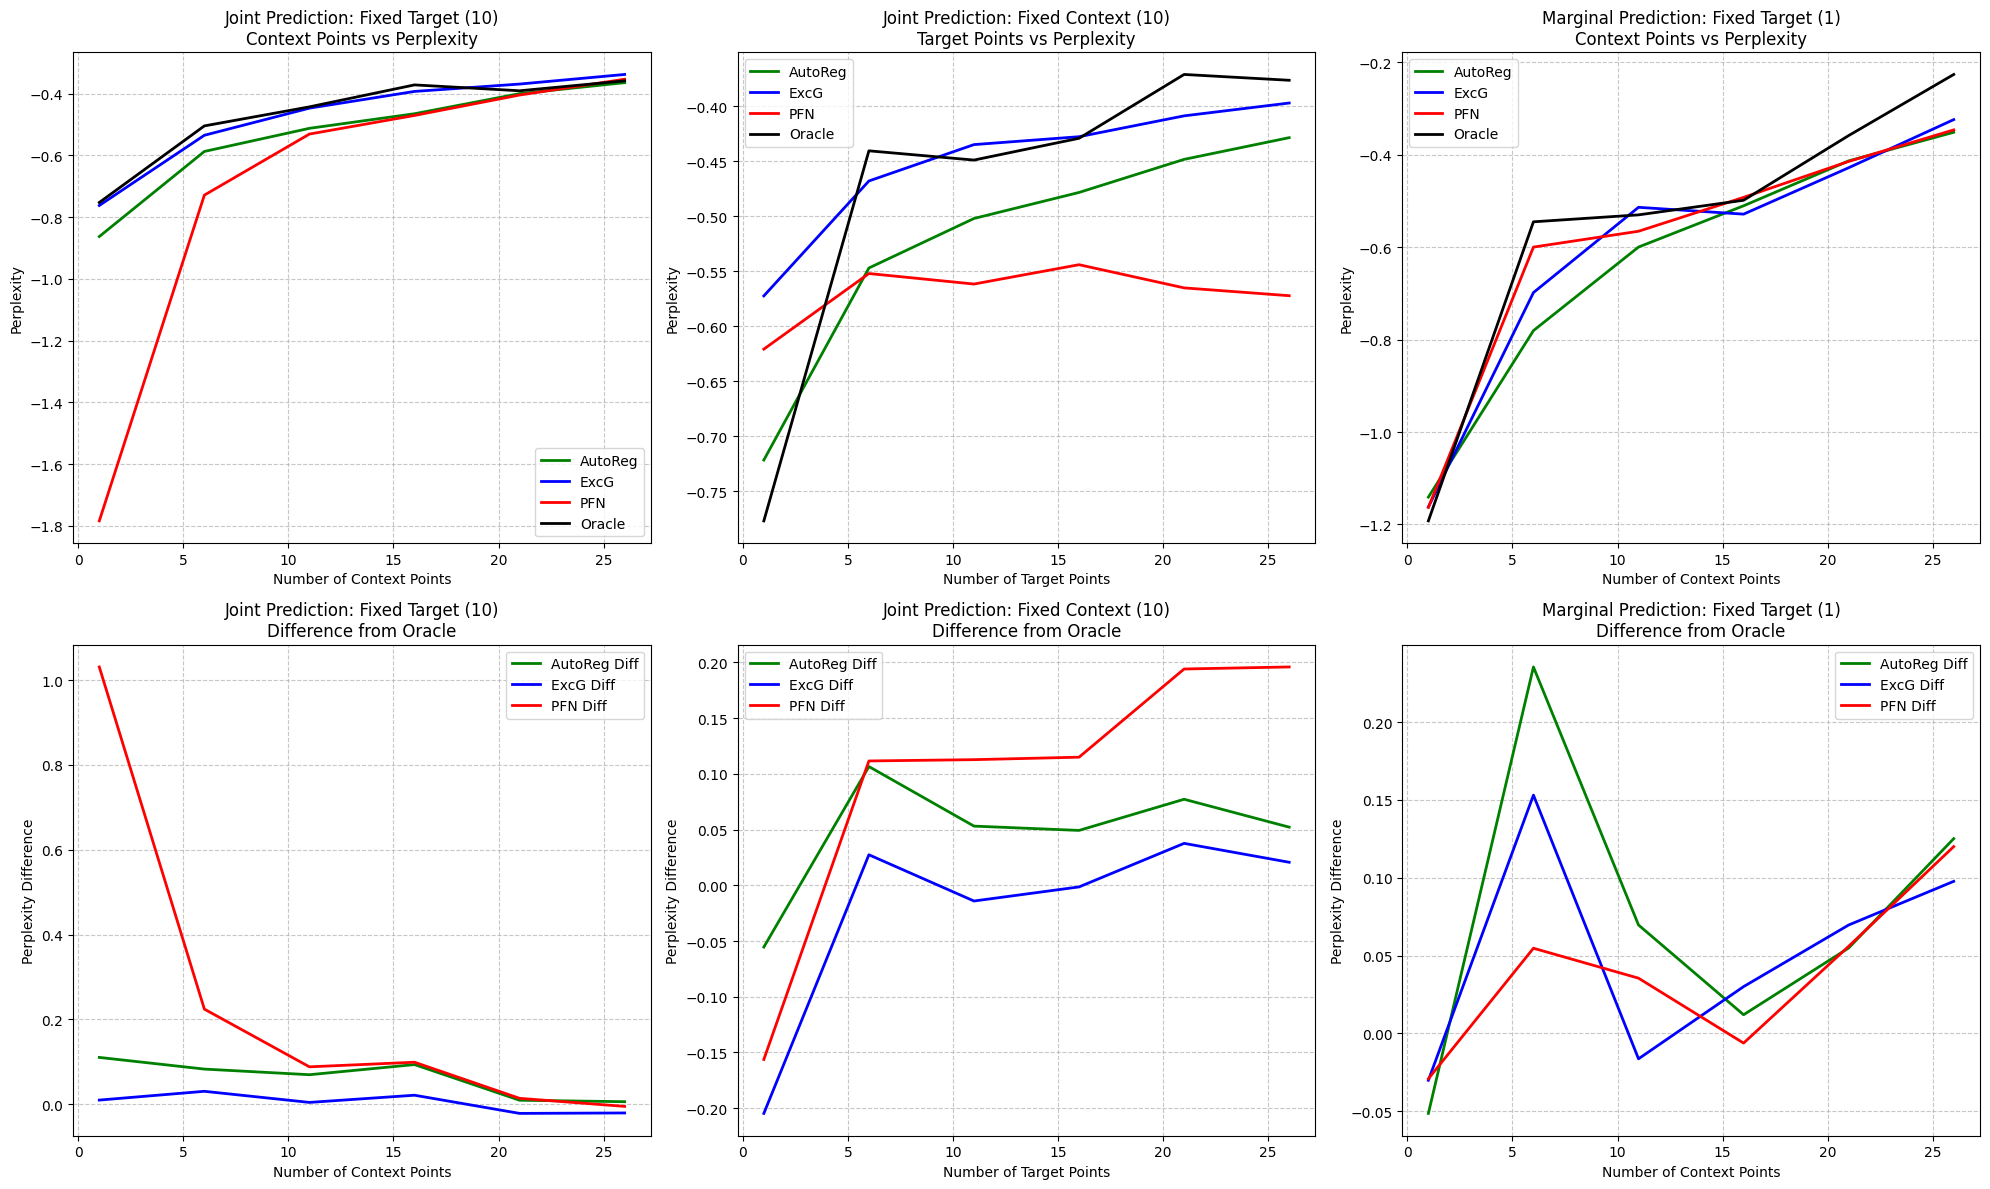

In [18]:
# Create the combined plots using the function from the previous code
create_combined_plots(start, end, step,
                     joint_context_data,
                     joint_target_data,
                     marginal_context_data)